# DBSCAN Clustering Notebook

**Original code**: [Alexandros Korkovelos](https://github.com/akorkovelos)<br>
**Conceptualization & Methodological review** : [Alexandros Korkovelos](https://github.com/akorkovelos)<br>
**Updates, Modifications**: [Alexandros Korkovelos](https://github.com/akorkovelos)<br>

## Importing packages

In [1]:
import os
import tkinter as tk
from tkinter import filedialog, messagebox
root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

import geopandas as gpd
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

import alphashape
from descartes import PolygonPatch

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
proj_crs = "epsg:32736"
def_crs = "epsg:4326"

## Import & prepare building footprint dataset

#### Importing dataset 

In [3]:
messagebox.showinfo('Extraction directory', 'Output folder')
workspace = filedialog.askdirectory()

filename_building_footprint = (filedialog.askopenfilename(filetypes = (("geopackage","*.gpkg"),("all files","*.*"))))
buildings=gpd.read_file(filename_building_footprint)

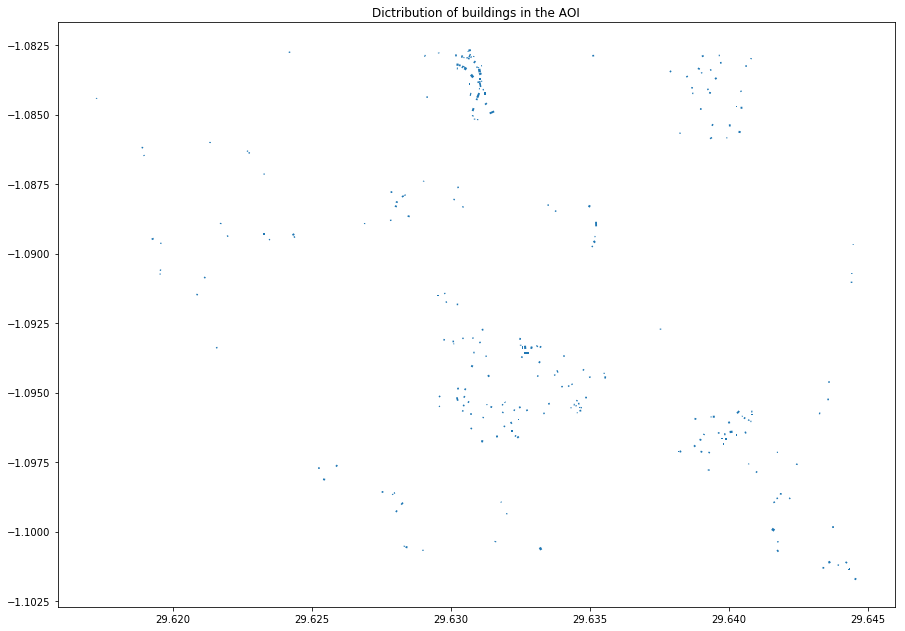

In [4]:
# Plotting geo-dataframe
fig, ax = plt.subplots(figsize=(15, 15))
buildings.plot(ax=ax)
ax.set_aspect('equal', 'box')
txt = ax.set_title('Dictribution of buildings in the AOI'.format(""))

#### Preping dataset

In [5]:
# Getting centroids of buildings
buildings_cent = buildings.centroid

In [6]:
buildings_centroid = gpd.GeoDataFrame(geometry=buildings_cent)

In [7]:
# Projecting geodataframe to coordinate system 
buildings_centroid = buildings_centroid.to_crs({'init': proj_crs})

## Creating lon/lat columns
buildings_centroid['lon'] = buildings_centroid["geometry"].x
buildings_centroid['lat'] = buildings_centroid["geometry"].y

In [8]:
# Preping the dataframe used to fit the clustering algorithm 
buildings_centroid_cluster = buildings_centroid[['lon', 'lat']]

## Running DBSCAL algorithm

In [9]:
# Fit model
buildings_centroid_cluster = StandardScaler().fit_transform(buildings_centroid_cluster)

In [10]:
# Run DBSCAN; For more info on the input variables look here: https://scikit-learn.org/stable/modules/clustering.html#dbscan
db = DBSCAN(eps=0.5, min_samples=5).fit(buildings_centroid_cluster)
labels = db.labels_
buildings_centroid["Cluster_ID"] = labels

In [11]:
# Print ID of identified clusters
buildings_centroid.Cluster_ID.unique()

array([ 0,  1,  2,  3,  4, -1], dtype=int64)

**Note!**

The DBSCAN algorith groups all "remote" points under index -1; These are considered as noise in the algorith. The number of clusters as well as what is considered as noise might change based on DBSCAN parameter calibration. See documentation here.

- [sklearn documentation](https://scikit-learn.org/stable/modules/clustering.html#dbscan)
- [DBSCAN Algorithm: Complete Guide and Application with Python Scikit-Learn](https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d)
- [Ester M. et al](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)
- [Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)

Other

- [Geospatial Clustering: Kinds and Uses](https://towardsdatascience.com/geospatial-clustering-kinds-and-uses-9aef7601f386#:~:text=The%20most%20well%20known%20density,with%20the%20application%20of%20noise%20.&text=DBSCAN%20algorithm%20visits%20every%20point,point%20is%20defined%20as%20noise.)
- [Qgis DBSCAN](https://docs.qgis.org/3.4/en/docs/user_manual/processing_algs/qgis/vectoranalysis.html?highlight=dbscan#dbscan-clustering)


In [12]:
buildings_centroid.head(5)

,geometry,lon,lat,Cluster_ID
0,POINT (124943.954 9880097.618),124943.954418,9.880098e+06,0
1,POINT (125366.777 9878715.273),125366.776566,9.878715e+06,1
2,POINT (126476.743 9878018.142),126476.743281,9.878018e+06,2
3,POINT (124897.122 9880097.421),124897.122313,9.880097e+06,0
4,POINT (125071.209 9878720.532),125071.209469,9.878721e+06,1


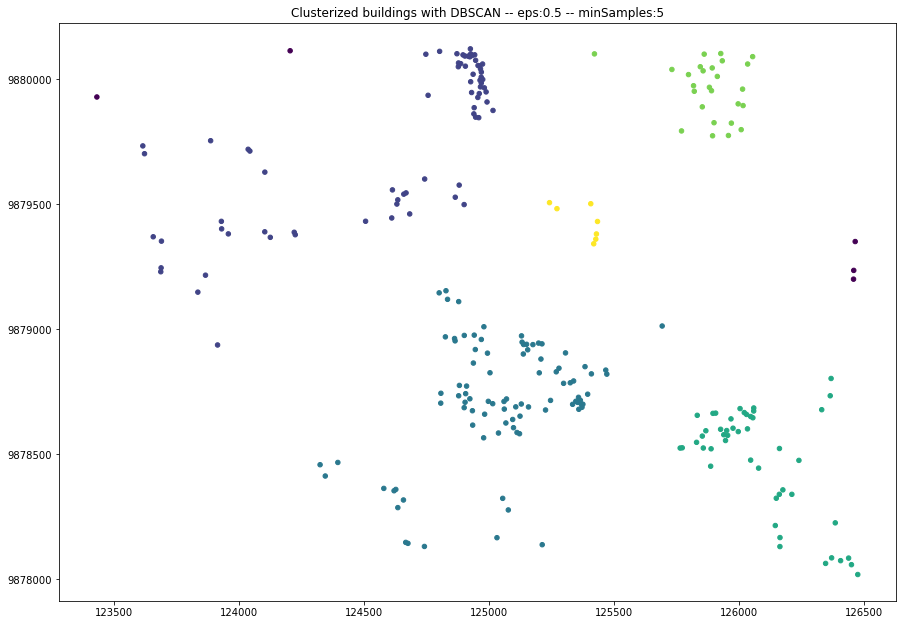

In [13]:
# Plot clustered buildings
fig, ax = plt.subplots(figsize=(15, 15))
buildings_centroid.plot(ax=ax, column='Cluster_ID', markersize=20, cmap="viridis")
ax.set_aspect('equal', 'box')
txt = ax.set_title('Clusterized buildings with DBSCAN -- eps:{} -- minSamples:{}'.format(0.5, 5))

## Calculate Convex hull -- Not optimal

In [14]:
# Dissolve all geometries by cluster ID
buildings_centroid_dissolved = buildings_centroid.dissolve(by="Cluster_ID")

# Eliminate buildings classified as -1 as they will distort the convex hull process
buildings_centroid_dissolved_non_clustered = buildings_centroid_dissolved[buildings_centroid_dissolved.index != -1]

# Calculate convex hull
buildings_polygons = buildings_centroid_dissolved_non_clustered.convex_hull

# Convert to geodataframe
buildings_polygons_gdf = gpd.GeoDataFrame(geometry=buildings_polygons)

# Re-aligh coordinate system
buildings_polygons_gdf.crs = {'init': proj_crs}
buildings_polygons_gdf = buildings_polygons_gdf.to_crs({'init': def_crs})

# Export gdf as as gpkg
buildings_polygons_gdf.to_file(workspace + r"/Sample_Convex_Clusters.shp")

## Calculate Concave Hull -- Better option

In [15]:
def get_cluster_geometry(data_frame, def_crs, proj_crs, alpha=None,):
    """
        Calculates the concave hull for a set of points that are classified by a Cluster_ID
        
        :data_frame: A geo-dataframe that contains a set of points; it shall contain a 'Cluster_ID' column that provides the cluster id that each points belongs to
        
        :alpha: float alpha value (e.g. 2.0); in case alpha is not defined, the algoritm will try to optimize the alpha value (look here https://pypi.org/project/alphashape/)
        
        :return: Two shp files; one containing the concave hull polygons and another the set of points that do not belong to a cluster
        
    """
    
    # Get the unique cluster index as provided by the DBSCAN algorithm
    clustering_index = np.unique(data_frame['Cluster_ID'].values)
    
    # Create two lists; one for unclustered points and another for clustered points that will form the polygons
    points = clustering_index[:1]
    clusters = clustering_index[1:]
    
    # First deal with points that are not clustered (value: -1); Get them and create a gdf from them
    points_df = data_frame.loc[data_frame['Cluster_ID'] == points[0], ['geometry']]
    points_gdf = polygon_gdf = gpd.GeoDataFrame(points_df, geometry='geometry')
    points_gdf.crs = {'init': proj_crs}
    points_gdf = points_gdf.to_crs({'init': def_crs})

    # Then create the concave hull for each cluster of points
    polygons = list()
    cluster_numbers = list()

    for cluster in clusters:
        # Filter out the cluster points
        points_df = data_frame.loc[data_frame['Cluster_ID'] == cluster, ['geometry']]
        
        # Then call the alpha_spape function; in case alpha is not defined, the algoritm will try to optimize the alpha value (look here https://pypi.org/project/alphashape/)
        alpha_shape = alphashape.alphashape(points_df, alpha=alpha)
        
        # Append polygon number & geometry to a geoseries
        polygons.append(alpha_shape['geometry'][0])
        cluster_numbers.append(cluster)
        
    # Create a pandas data frame to store the concave hull polygons
    polygon_df = pd.DataFrame.from_dict(data={'cluster': cluster_numbers, 'geometry': polygons})
    
    # Create the GeoPandas data frame to display on the map
    polygon_gdf = gpd.GeoDataFrame(polygon_df)
    
    # Add buffer so that buildings are enclosed within the polygon (OPTIONAL)
    polygon_gdf['geometry'] = polygon_gdf.geometry.buffer(5)   # im meters
    
    # Revert dataframe to common CRS
    polygon_gdf.crs = {'init': proj_crs}
    polygon_gdf = polygon_gdf.to_crs({'init': def_crs})
    
    # Export the two geodataframes 
    points_gdf.to_file(workspace + r'/Sample_Concave_non_clustered_buildings.shp')
    polygon_gdf.to_file(workspace + r"/Sample_Concave_clustered_buildings.shp")


In [16]:
get_cluster_geometry(buildings_centroid, def_crs, proj_crs)